In [1]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

# Initializations

### Generate non-linear data

In [3]:
n_samples = 800
input_dim = 3
input = torch.FloatTensor(n_samples, input_dim).uniform_(-1,1)

### Initialize weights and bias

In [4]:
weights_true = torch.FloatTensor([[2.0, 6.0, 8.0]]).T
bias_true = torch.tensor([0.5, 0.25])
y_true = (torch.einsum('ij, jk -> ik', (input**3),  weights_true) + torch.einsum('ij, jk -> ik', (input**2),  weights_true) + torch.einsum('ij, jk -> ik', input, weights_true) + bias_true).float()


x_tensor = input.clone().detach().requires_grad_(True).float()
y_true_tensor = y_true.clone().detach().requires_grad_(True).float()

print(f'x: {x_tensor.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true_tensor.shape}')

x: torch.Size([800, 3]), weights: torch.Size([3, 1]), bias: torch.Size([2]), y: torch.Size([800, 2])


### Hyperparameter initializations

In [5]:
input_dim = 3
output_dim = 1
num_hidden = 16

alpha = 0.01
epochs = 30



# Model Class

### Class Definition

In [6]:
class Model(pl.LightningModule):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.relu2 = nn.ReLU()
    self.linear3 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3

  def training_step(self, batch):
    x, y_true = batch
    y_pred = self(x)
    loss_value = nn.MSELoss()(y_pred, y_true)
    return loss_value

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=alpha)
    return optimizer

### Data Loader

In [7]:
batch_size = 10
data = TensorDataset(input, y_true)
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

### Trainer and model initialization

In [8]:
trainer = pl.Trainer(max_epochs=epochs)
model = Model(input_dim, output_dim, num_hidden)

/usr/local/lib/python3.9/dist-packages/lightning_fabric/accelerators/cuda.py:236: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Train Model

In [9]:
trainer.fit(model, data_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 64    
1 | relu1   | ReLU   | 0     
2 | linear2 | Linear | 272   
3 | relu2   | ReLU   | 0     
4 | linear3 | Linear | 17    
-----------------------------------
353       Trainable params
0         Non-trainable params
353       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10, 2])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


We can see that after 30 epochs at batch size 10, the MSSE loss is 1

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot(x, y_true, y_pred):
  tsne = TSNE(n_components=1, random_state=0)
  x_2d = tsne.fit_transform(x)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(x_2d[:, 0], yt_2d[:, 0], c='b', label='y_true')
  plt.scatter(x_2d[:, 0], yp_2d[:, 0], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Distribution plot for y_true and y_pred with X')
  plt.show()

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='y_true')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='y_pred')
  plt.legend()
  
     

In [16]:
y_pred_np = (model.forward(input)).detach().numpy()
y_true_np = y_true.detach().numpy()
x_np = input.detach().numpy()

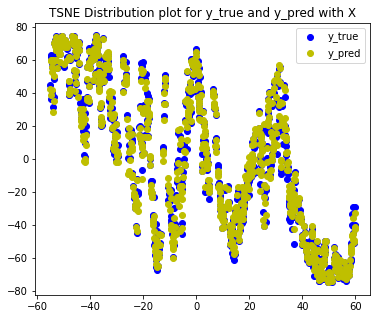

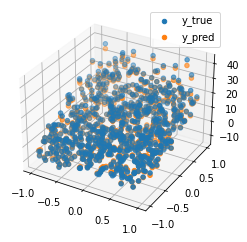

In [17]:
plot(x_np, y_true_np, y_pred_np)
plot_3d(x_np, y_true_np[:, 0], y_pred=y_pred_np[:, 0])